## Testing Model

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image   
from typing import Callable

class TextToImage:
    pipe: StableDiffusionPipeline | None = None

    def load_model(self) -> None:
        # Enable CUDA GPU
        if torch.cuda.is_available():
            device = "cuda"
        # Enable Apple Silicon (M1) GPU
        elif torch.backends.mps.is_available():
            device = "mps"
        # Fallback to CPU
        else:
            device = "cpu"

        ############################################## UNZIP
        # pipe = StableDiffusionPipeline.from_pretrained('./sd3-model',torch_dtype=torch.bfloat16)
        # img = pipe('stars and space')
        # img[0][0]
        ############################################## UNZIP
        pipe = StableDiffusionPipeline.from_pretrained("OFA-Sys/small-stable-diffusion-v0", torch_dtype=torch.bfloat16)
        pipe.to(device)
        pipe.enable_model_cpu_offload()
        #  this method moves one whole model at a time to the GPU when its `forward` method is called

        self.pipe = pipe

    def generate(
        self,
        prompt: str,
        *,
        negative_prompt: str | None = None,
        num_steps: int = 150,
        callback: Callable[[int, int, torch.FloatTensor], None] | None = None,
    ) -> Image.Image:
        if not self.pipe:
            raise RuntimeError("Pipeline is not loaded")
        return self.pipe(
            prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=num_steps,
            guidance_scale=9.0,
            callback=callback,
        ).images[0]


text_to_image = TextToImage()
text_to_image.load_model()


################### bfloat16
# loaded model
## memory-usage::   2207MiB 
# running model
## memory-usage:: 3401MiB 

################### float32
# loaded model
## memory-usage:: 4369MiB
# running model
## memory-usage:: 4.9GB


image = text_to_image.generate(
    # "A Renaissance castle in the Loire Valley",
    "Line art for Casterly Rock castel",
    negative_prompt="low quality, ugly",
    # callback=callback,
)
image.save("output.png")

## save pretrained
# text_to_image.pipe.save_pretrained("./sd3-model")


# Inference

In [1]:
import requests
import numpy as np
from PIL import Image
import json

In [2]:
!curl -v -X PUT "http://localhost:8081/models/sd3?min_workers=2&batch_size=8"

* Host localhost:8081 was resolved.
* IPv6: ::1
* IPv4: 127.0.0.1
*   Trying [::1]:8081...
* Connected to localhost (::1) port 8081
> PUT /models/sd3?min_workers=2&batch_size=8 HTTP/1.1
> Host: localhost:8081
> User-Agent: curl/8.5.0
> Accept: */*
> 
< HTTP/1.1 202 Accepted
< content-type: application/json
< x-request-id: c9f6219c-71c5-4f7f-a9aa-0d130a547d7e
< Pragma: no-cache
< Cache-Control: no-cache; no-store, must-revalidate, private
< Expires: Thu, 01 Jan 1970 00:00:00 UTC
< content-length: 47
< connection: keep-alive
< 
{
  "status": "Processing worker updates..."
}
* Connection #0 to host localhost left intact


In [6]:
res = requests.post(
            "http://localhost:8080/predictions/sd3",
            data="dramatic swirling cosmos in the sky, Earth glowing like a jewel, violent brushstrokes suggesting dust storms, intense light and shadow contrasts"
        )

<class 'str'>
<PIL.Image.Image image mode=RGB size=1024x1024 at 0x7776801066D0>


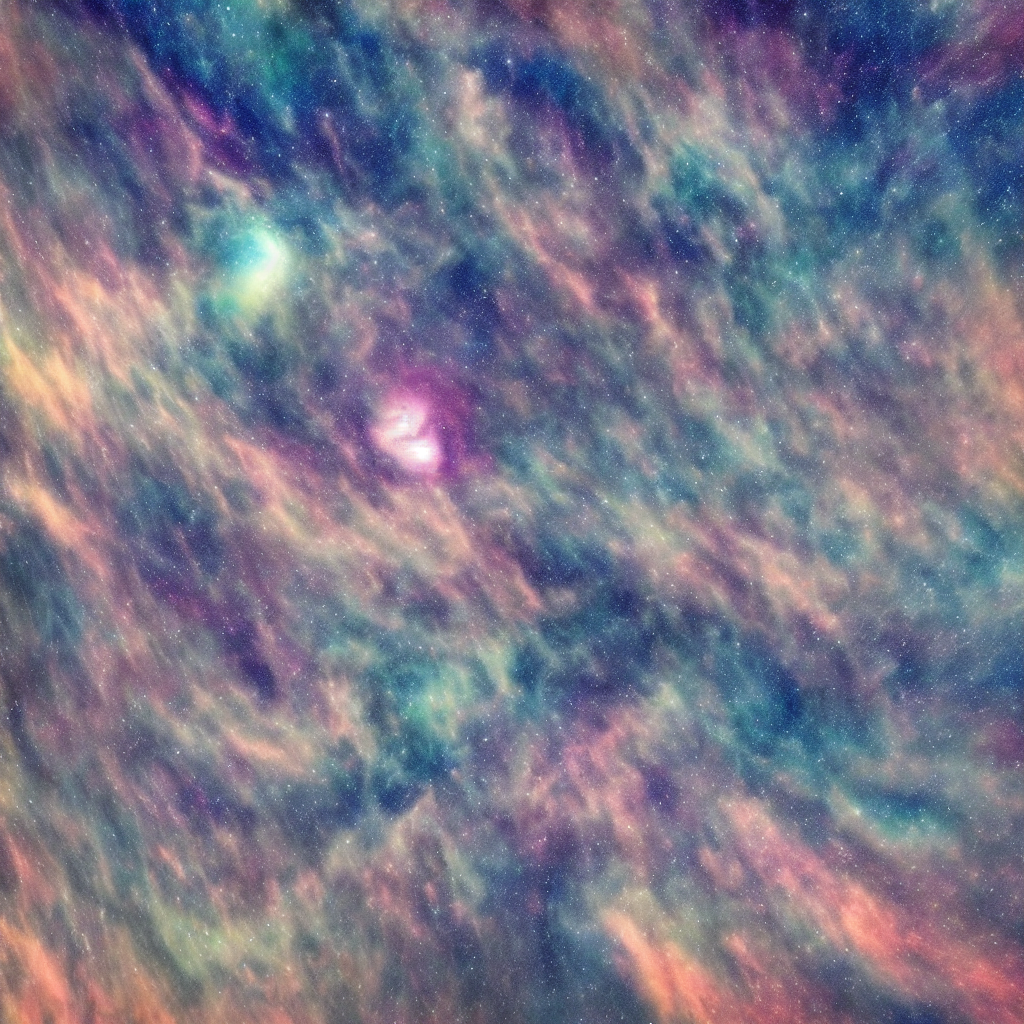

In [7]:
if res.status_code==200:
    print(type(res.text))
    json_loads = json.loads(res.text)
    array = np.array(json_loads,dtype="uint8")
    imge = Image.fromarray(array)
    print(imge)
    display(imge)

# S3

```py
# Initialize S3 client

########################################################################################################################################
#   # https://github.com/boto/boto3/issues/3710  
#
#   while trying presigned_url later showing 
#    <Code>SignatureDoesNotMatch</Code>
#    <Message>The request signature we calculated does not match the signature you provided. Check your key and signing method.</Message>
#
########################################################################################################################################

s3_client = boto3.client(
                    's3',
                    config=Config(
                            signature_version="s3v4",
                            region_name="ap-south-1",
                            s3={"addressing_style": "path"}
                    ),
                    region_name="ap-south-1",
                    aws_access_key_id=ACCESSS_KEY,
                    aws_secret_access_key=SCERET
)

```

```py
import boto3
import json 

BUCKET_NAME = r"sd3-bucket"


client = boto3.client(
                    's3',
                    region_name="ap-south-1",
                    aws_access_key_id= os.environ.get('AWS_ACCESS_KEY'),
                    aws_secret_access_key  = os.environ.get('AWS_ACCESS_SECRET')
)
print(client)
print(client.list_buckets())


# create
client.create_bucket(
            Bucket=BUCKET_NAME,
            CreateBucketConfiguration = { 
                'LocationConstraint':'ap-south-1',
            }) # ACL='public-read',

# access
client.put_public_access_block(
    Bucket=BUCKET_NAME,
    PublicAccessBlockConfiguration={
        "BlockPublicAcls": False,
        "IgnorePublicAcls": False,
        "BlockPublicPolicy": False,
        "RestrictPublicBuckets": False
    }
)

# policy 
client.put_bucket_policy(
    Bucket='sd3-bucket',
    Policy= json.dumps({
                        "Version": "2012-10-17",  # Ensure this version string is present and correct
                        "Statement": [
                            {
                                "Sid": "PublicReadGetObject",
                                "Effect": "Allow",
                                "Principal": "*",
                                "Action": "s3:GetObject",
                                "Resource": f"arn:aws:s3:::{BUCKET_NAME}/*"
                            }
                        ]
                    })
)


# Upload
client.upload_file(Filename='prompts.txt',Bucket=BUCKET_NAME ,Key='hello.txt')

# Presigned URL
presigned_url = s3_client.generate_presigned_url(
            "get_object",
            Params={"Bucket": BUCKET_NAME, "Key": FILENAME},
            ExpiresIn=3600 * 24,  # 24 hours
        )
```